In [7]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [5]:
with open('superheroes.txt','r') as f:
  data = f.read()

In [8]:
tokenizer = tf.keras.preprocessing.text.Tokenizer( 
    filters='!"#$%&()+,/;<=>?@[\\]^_`{|}~', #filters the chraters that we dont want to use in our vocabulary
    split='\n', #slpit out data with \n
)

In [14]:
tokenizer.fit_on_texts(data) #fit our tokenizer in this data, sequemce to char

In [15]:
char_to_index = tokenizer.word_index #word index in tokenizer
index_to_char = dict((v, k) for k,v in char_to_index.items())  #value for key 
#another dictionary that index to charaters just incase to do the exact opposite operation

print(index_to_char)

{1: '\t', 2: 'a', 3: 'e', 4: 'r', 5: 'o', 6: 'n', 7: 'i', 8: ' ', 9: 't', 10: 's', 11: 'l', 12: 'm', 13: 'h', 14: 'd', 15: 'c', 16: 'u', 17: 'g', 18: 'k', 19: 'b', 20: 'p', 21: 'y', 22: 'w', 23: 'f', 24: 'v', 25: 'j', 26: 'z', 27: 'x', 28: 'q'}


In [16]:
names = data.splitlines()
names[:10] #give names

['jumpa\t',
 'doctor fate\t',
 'starlight\t',
 'isildur\t',
 'lasher\t',
 'varvara\t',
 'the target\t',
 'axel\t',
 'battra\t',
 'changeling\t']

In [17]:
tokenizer.texts_to_sequences(names[0]) #indicates the nemirecic   

[[25], [16], [12], [20], [2], [1]]

In [18]:
def name_to_seq(name):
  return[tokenizer.texts_to_sequences(c)[0][0]for c in name] #list

In [19]:
name_to_seq(names[0])

[25, 16, 12, 20, 2, 1]

In [20]:
def seq_to_name(seq):
  return ''.join([index_to_char[i] for i in seq if i != 0]) #recursive function return space and join seq then seq to char

In [21]:
seq_to_name(name_to_seq(names[0]))

'jumpa\t'

In [22]:
sequences = []

for name in names:
  seq = name_to_seq(name)
  if len(seq) >=2:
    sequences += [seq[:i] for i in range(2,len(seq) + 1 )]

In [23]:
sequences[:10]

[[25, 16],
 [25, 16, 12],
 [25, 16, 12, 20],
 [25, 16, 12, 20, 2],
 [25, 16, 12, 20, 2, 1],
 [14, 5],
 [14, 5, 15],
 [14, 5, 15, 9],
 [14, 5, 15, 9, 5],
 [14, 5, 15, 9, 5, 4]]

In [24]:
max_len = max([len(x) for x in sequences])
print(max_len)

33


In [25]:
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(
    sequences, padding ='pre',
    maxlen = max_len
)

print(padded_sequences[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 25 16]


In [26]:
padded_sequences.shape

(88279, 33)

In [27]:
x, y = padded_sequences[:, :-1], padded_sequences[:,-1]
print(x.shape,y.shape) #get x and y     , x examples,labels . length of sequence. y

(88279, 32) (88279,)


In [28]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y) #train test split . train and test first

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(66209, 32) (66209,)
(22070, 32) (22070,)


In [29]:
num_chars = len(char_to_index.keys()) + 1 #zero to vocabulary is the +1
print(num_chars)

29


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPool1D, LSTM
from tensorflow.keras.layers import Bidirectional, Dense

model = Sequential([
                    Embedding(num_chars, 8, input_length=max_len-1),
                    Conv1D(64, 5, strides=1, activation='tanh', padding='causal'),
                    MaxPool1D(2),
                    LSTM(32),
                    Dense(num_chars,activation='softmax'),
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 8)             232       
_________________________________________________________________
conv1d (Conv1D)              (None, 32, 64)            2624      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 29)                957       
Total params: 16,229
Trainable params: 16,229
Non-trainable params: 0
_________________________________________________________________


In [31]:
h = model.fit(
    x_train, y_train,
    validation_data = (x_test,y_test),
    epochs=50, verbose = 2,
    callbacks = [
                 tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience=3)
    ]     
)

Epoch 1/50
2070/2070 - 45s - loss: 2.7449 - accuracy: 0.1854 - val_loss: 2.5913 - val_accuracy: 0.2222
Epoch 2/50
2070/2070 - 15s - loss: 2.5536 - accuracy: 0.2312 - val_loss: 2.5057 - val_accuracy: 0.2432
Epoch 3/50
2070/2070 - 15s - loss: 2.4859 - accuracy: 0.2506 - val_loss: 2.4512 - val_accuracy: 0.2626
Epoch 4/50
2070/2070 - 15s - loss: 2.4385 - accuracy: 0.2632 - val_loss: 2.4150 - val_accuracy: 0.2712
Epoch 5/50
2070/2070 - 15s - loss: 2.4011 - accuracy: 0.2712 - val_loss: 2.3843 - val_accuracy: 0.2776
Epoch 6/50
2070/2070 - 15s - loss: 2.3711 - accuracy: 0.2806 - val_loss: 2.3648 - val_accuracy: 0.2860
Epoch 7/50
2070/2070 - 15s - loss: 2.3438 - accuracy: 0.2907 - val_loss: 2.3417 - val_accuracy: 0.2973
Epoch 8/50
2070/2070 - 15s - loss: 2.3194 - accuracy: 0.2972 - val_loss: 2.3219 - val_accuracy: 0.3024
Epoch 9/50
2070/2070 - 15s - loss: 2.2984 - accuracy: 0.3045 - val_loss: 2.3126 - val_accuracy: 0.3010
Epoch 10/50
2070/2070 - 15s - loss: 2.2785 - accuracy: 0.3110 - val_loss:

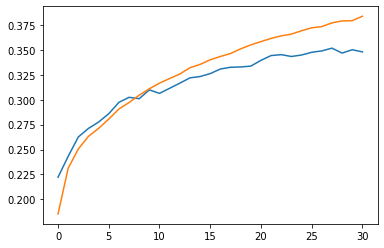

In [34]:
from matplotlib import pyplot as plt

epochs_ran= len(h.history['loss'])  #calculate the loss which is the 

plt.plot(range(0,epochs_ran), h.history['val_accuracy'], label='Validation') # validation accuracy
plt.plot(range(0,epochs_ran), h.history['accuracy'], label='Training') #training accuracy 
plt.show()  

## Task 8: Generate Names!

In [35]:
def generate_names(seed):
  for i in range(0,40):
    seq= name_to_seq(seed)
    padded = tf.keras.preprocessing.sequence.pad_sequences([seq],
                                                           padding='pre',
                                                           maxlen=max_len-1,
                                                           truncating='pre',
                                                           )
    pred = model.predict(padded)[0]
    pred_char = index_to_char[tf.argmax(pred).numpy()]
    seed += pred_char

    if pred_char == '\t':
      break
  print(seed)

In [51]:
generate_names('u')

ultrain	


In [137]:
for i in range(ord('A'), ord('Z')+1):
    generate_names(chr(i))

Artinas	
Batman	
Captain man	
Dorman	
Elessitl	
Frand stark	
Green man	
Herman	
Iron man	
Jack sharr	
Karlo	
Lestor	
Mantis	
Nightwing	
Onessit	
Porman	
Quintsan man	
Red the hulk	
Spiderman	
The superman	
Ultrain	
Verdel superman	
Warlo	
Xarin man	
Yander superman	
Zarlo	
